In [1]:
#import statements
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten,Dropout,MaxPooling1D, Input, Dense, LSTM, RepeatVector,TimeDistributed, Flatten,Bidirectional,Conv1D, GRU, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Concatenate, concatenate
from tensorflow.keras.layers import DenseFeatures
import random
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pickle
import matplotlib.pyplot as plt

In [2]:
def read_pickleFile(filename):
    # returns dump pickle file object
    with open (filename,'rb') as pf:
        new_data=pickle.load(pf, encoding="bytes")
    return new_data

In [3]:
filename='human_cells_170_stimulus.pkl'
new_data=read_pickleFile(filename)
i=new_data[str.encode('i')]
t=new_data[str.encode('t')]
v=new_data[str.encode('v')]
ids=new_data[str.encode('id')]



In [4]:
# stimulus_df = pd.DataFrame(i[0],columns=["stimulus"])
response_df = pd.DataFrame(v[0],columns=["response"])
time_df = pd.DataFrame(t[0],columns=["time"])
for i_index in range(1,len(i)):
    response_df=response_df.append(pd.DataFrame(v[i_index],columns=["response"]),ignore_index=True)
#     stimulus_df=stimulus_df.append(pd.DataFrame(i[i_index],columns=["stimulus"]),ignore_index=True)
    time_df=time_df.append(pd.DataFrame(t[i_index],columns=["time"]),ignore_index=True)

df=time_df.join(response_df)
df

,time,response
0,1.01000,-70.187500
1,1.01002,-70.187500
2,1.01004,-70.218758
3,1.01006,-70.218758
4,1.01008,-70.281250
...,...,...
17422495,2.01990,-41.562500
17422496,2.01992,-41.625000
17422497,2.01994,-41.593754
17422498,2.01996,-41.593754


In [5]:
df["response"]=df["response"].astype(np.int32)
df["response"].dtypes

dtype('int32')

In [6]:
subsample=20
batch_size = 256
# subsampled sequence length
# sequence_length = 2525
sequence_length = 50500 #timesteps for each specimen
x_data = df["response"].values[0::,]
y_data = df["response"].values[0::,]
y_data = y_data.reshape(-1, 1)
x_data = x_data.reshape(-1, 1)
print(type(y_data))
print("input Shape:", x_data.shape)
print("output Shape:", y_data.shape)
num_data = len(x_data)
#dividing test and train set
num_train = 300*sequence_length
num_test = num_data - num_train
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals=y_data.shape[1]




<class 'numpy.ndarray'>
input Shape: (17422500, 1)
output Shape: (17422500, 1)


In [7]:
#generator function for training
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    idx=[]
    y_scaler = StandardScaler()
    for i in range(0,num_train,sequence_length):
        idx.append(i)
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.int32)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.int32)
        
        
        # Fill the batch with random sequences of data.
        idxx=0
        remove_list=[]
        for i in range(batch_size):
            # Get a random start-index.         
            idxx = random.choice(idx)
            idx.remove(idxx)
            remove_list.append(idxx)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train[idxx:idxx+sequence_length]
            y_batch[i] = y_train[idxx:idxx+sequence_length]
            y_batch[i] = y_scaler.fit_transform(y_batch[i])
            x_batch[i] = y_scaler.fit_transform(x_batch[i])
     
        for i in remove_list:
            idx.append(i)
            
#         subsequences = 1
#         timesteps = x_batch.shape[1]//subsequences
#         x_batch= x_batch.reshape((x_batch.shape[0], timesteps, x_batch.shape[2]))
#         y_batch=y_batch.reshape((y_batch.shape[0],y_batch.shape[1],y_batch.shape[2]))
        subsequences = 5
        timesteps = x_batch.shape[1]//subsequences
        x_batch= x_batch.reshape((x_batch.shape[0],subsequences, timesteps, x_batch.shape[2]))
        y_batch=y_batch.reshape((y_batch.shape[0],subsequences, timesteps,y_batch.shape[2]))
        x_batch=x_batch.astype(np.int32)
        y_batch=y_batch.astype(np.int32)
        yield (x_batch, y_batch)

In [8]:
#test set generator 
def test_batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of testing-data.
    """
    test_idx=[]
    y_scaler = StandardScaler()
    for i in range(0,num_test,sequence_length):
        test_idx.append(i)
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_test_batch = np.zeros(shape=x_shape, dtype=np.int32)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_test_batch = np.zeros(shape=y_shape, dtype=np.int32)       
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
#         for i in range(batch_size):
            # Get a random start-index.
            idxx = random.choice(test_idx)
            test_idx.remove(idxx)
            
            # Copy the sequences of data starting at this index.
            x_test_batch[i] = x_test[idxx:idxx+sequence_length]
            y_test_batch[i] = y_test[idxx:idxx+sequence_length]
            y_test_batch[i] =  y_scaler.fit_transform(y_test_batch[i])
            x_test_batch[i] =  y_scaler.fit_transform(x_test_batch[i])
#             y_test_batch[i]=y_test_batch[i]/100
#             x_test_batch[i]=x_test_batch[i]/100
        
        for i in range(0,num_test,sequence_length):
            test_idx.append(i)
            
        subsequences = 5
        timesteps = x_test_batch.shape[1]//subsequences
        x_test_batch= x_test_batch.reshape((x_test_batch.shape[0],subsequences, timesteps, x_test_batch.shape[2]))
        y_test_batch=y_test_batch.reshape((y_test_batch.shape[0],subsequences, timesteps, y_test_batch.shape[2]))
        x_test_batch=x_test_batch.astype(np.int32)
        y_test_batch=y_test_batch.astype(np.int32)
        yield (x_test_batch, y_test_batch)

In [9]:
test_generator = test_batch_generator(batch_size=4,
                            sequence_length=sequence_length)

In [10]:
generator = batch_generator(batch_size=16,
                            sequence_length=sequence_length)

In [11]:
x_batch, y_batch = next(generator)
print(x_batch.shape)


(16, 5, 10100, 1)


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
x_test_batch,y_test_batch=next(test_generator)

In [13]:
x_test_batch.shape

(4, 5, 10100, 1)

In [14]:
validation_data = (x_test_batch,
                  y_test_batch)

In [15]:

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [29]:
#uncomment while training
# path_checkpoint = 'checkpoint_conv1d_int32_5_just_conv1D_dense.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)

In [25]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [30]:
#uncomment while training
# callback_tensorboard = TensorBoard(log_dir='./logs/checkpoint_conv1d_int32_5_just_conv1D_dense.keras/',
#                                    histogram_freq=0,
#                                    write_graph=False)

In [27]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.2,
                                       min_lr=0.01,
                                       patience=3,
                                       verbose=1)

In [31]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [29]:
x_batch.shape

(16, 5, 10100, 1)

In [32]:
subsequences=5
timesteps=10100
# timesteps=505

In [33]:
def get_model_conv():
    num_units=64
    input_layer = Input(shape=(None,x_batch.shape[2],x_batch.shape[3]))
    conv=TimeDistributed(Conv1D(filters=5, kernel_size=128, padding="same",activation='relu'))(input_layer)
    dense=TimeDistributed(Dense(num_units))(conv)
    dense=TimeDistributed(Dense(1))(dense)   
    autoencoder = Model(input_layer, dense)
    print(autoencoder.summary())
    return autoencoder

In [35]:
model = get_model_conv()

model.compile(loss='mean_squared_error', optimizer='adam')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 10100, 1)]  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10100, 5)    645       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 10100, 64)   384       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 10100, 1)    65        
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________
None


In [100]:
hist=model.fit_generator(generator=generator,
                    epochs=35,
                    steps_per_epoch=100,
                       validation_data=validation_data,callbacks=callbacks)
hist

  ...
    to  
  ['...']
Train for 100 steps, validate on 4 samples
Epoch 1/35


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


 99/100 [============================>.] - ETA: 1s - loss: 0.2862
Epoch 00001: val_loss improved from 0.22374 to 0.18217, saving model to checkpoint_conv1D_Pooling_dense.keras
100/100 [==============================] - 179s 2s/step - loss: 0.2856 - val_loss: 0.1822
Epoch 2/35
 99/100 [============================>.] - ETA: 1s - loss: 0.1607
Epoch 00002: val_loss improved from 0.18217 to 0.15311, saving model to checkpoint_conv1D_Pooling_dense.keras
100/100 [==============================] - 177s 2s/step - loss: 0.1597 - val_loss: 0.1531
Epoch 3/35
 99/100 [============================>.] - ETA: 1s - loss: 0.1352
Epoch 00003: val_loss did not improve from 0.15311
100/100 [==============================] - 176s 2s/step - loss: 0.1358 - val_loss: 0.1769
Epoch 4/35
 99/100 [============================>.] - ETA: 1s - loss: 0.1147
Epoch 00004: val_loss improved from 0.15311 to 0.14115, saving model to checkpoint_conv1D_Pooling_dense.keras
100/100 [==============================] - 176s 2s/s

In [36]:
#ker contains layer outputs
from matplotlib import pyplot
ker=[]
for layer in model.layers:
    if len(layer.get_weights())>0:
        print(layer.get_weights()[0].shape)
        ker.append(layer.get_weights()[0])
    print(layer.get_config(), layer.get_weights())

{'name': 'input_2', 'batch_input_shape': (None, None, 10100, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False} []
(128, 1, 5)
{'name': 'time_distributed_3', 'dtype': 'float32', 'layer': {'config': {'name': 'conv1d_1', 'filters': 5, 'kernel_initializer': {'config': {'seed': None}, 'class_name': 'GlorotUniform'}, 'padding': 'same', 'bias_regularizer': None, 'kernel_size': (128,), 'dtype': 'float32', 'kernel_regularizer': None, 'activation': 'relu', 'activity_regularizer': None, 'kernel_constraint': None, 'bias_initializer': {'config': {}, 'class_name': 'Zeros'}, 'data_format': 'channels_last', 'trainable': True, 'use_bias': True, 'strides': (1,), 'dilation_rate': (1,), 'bias_constraint': None}, 'class_name': 'Conv1D'}, 'trainable': True} [array([[[-0.03006246, -0.03076981,  0.00601347,  0.07811105,
          0.0855998 ]],

       [[-0.02436056,  0.08214305, -0.02899282, -0.0633068 ,
          0.05509318]],

       [[-0.0798762 ,  0.07069714, -0.07335181, -0.0690269 ,
         -0.

In [48]:
ker[1][:,0].shape

(5,)

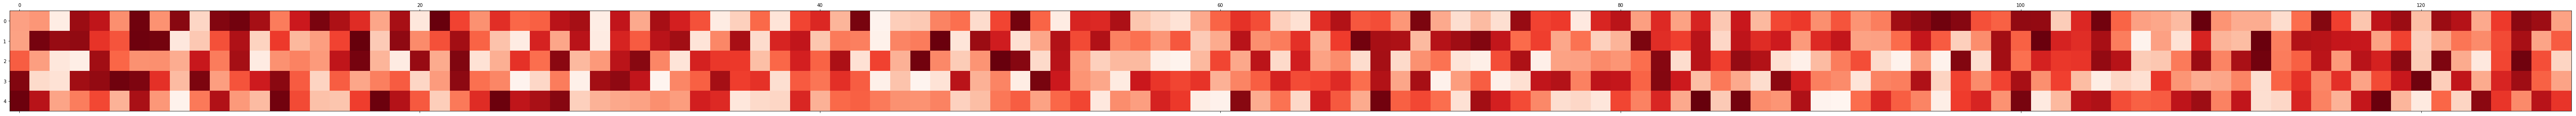

In [44]:
import matplotlib.pyplot as plt
# plt.matshow(ker[0][:,0].T, cmap='Reds')

fig, ax = plt.subplots(figsize=(100,10))
ax.matshow(ker[0][:,0].T, cmap='Reds')

In [45]:
# import matplotlib.pyplot as plt
# kernal1=ker[1].reshape(128,)
# plt.plot(kernal1, c='r')
# plt.show()

In [49]:
model.layers[1].output

<tf.Tensor 'time_distributed_3/Identity:0' shape=(None, None, 10100, 5) dtype=float32>

In [50]:
model1 = Model(inputs=model.inputs, outputs=model.layers[1].output)

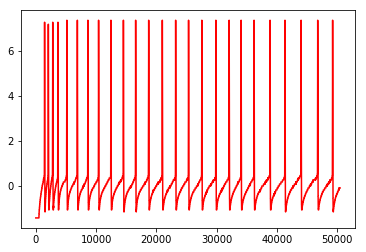

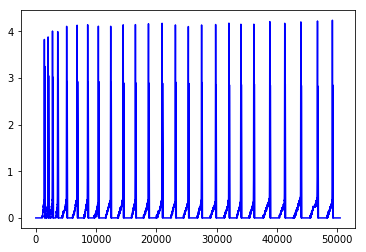

In [51]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scaler = StandardScaler()

i=0
y=x_test[sequence_length*i:(sequence_length*i)+sequence_length]
    # x=x_test[50500]
    # print("Min:", np.min(y))
    # print("Max:", np.max(y))
y=scaler.fit_transform(y)
# print("Min:", np.min(y))
# print("Max:", np.max(y))
len(y)
y=y.reshape(1,5,10100,1)
y_to=y.reshape(sequence_length,)
plt.plot(y_to, c='r')
plt.show()
predicted = model1.predict(y)
    # print("Min:", np.min(predicted))
    # print("Max:", np.max(predicted))

predicted1=predicted[0:,:,:,:1].reshape(sequence_length,)
# print(predicted[0:,:,:,:1].shape)

plt.plot(predicted1,c='b',label='predicted')
plt.show()


In [52]:
p=predicted.reshape(50500,5)
predicted1[predicted1==0.0]=np.nan
fig, ax1 = plt.subplots(figsize=(100,10))
ax1.plot(predicted1,c='b',label='predicted')
ax1.imshow(p.T,aspect=1000,cmap='Reds')
plt.show()

(1, 5, 10100, 5)

In [ ]:
fig, bx = plt.subplots()
p[p==0.0]=np.nan
bx.imshow(p.T,aspect='auto',cmap='Reds')

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
y=pdist(p.T)
dendrogram = sch.dendrogram(sch.linkage(y, method='ward'))

plt.title('Dendrogram')

plt.show()

In [53]:
print(x_train.shape)
x_train_new=x_train.reshape(300,5,10100,1)

(15150000, 1)


In [54]:
print(x_test.shape)
x_test_new=x_test.reshape(45,5,10100,1)


(2272500, 1)


In [56]:
num_train_samples=300
num_test_samples=45

In [57]:
sub_x_train=x_train_new[0:num_train_samples:,:]

In [58]:
sub_x_test=x_test_new[0:num_test_samples:,:]

In [59]:
scalar=StandardScaler()

In [60]:
sub_x_train=sub_x_train.reshape(num_train_samples,5,10100,1)
# sub_x_train=scalar.fit_transform(sub_x_train)
sub_x_test=sub_x_test.reshape(num_test_samples,5,10100,1)
# sub_x_test=scalar.fit_transform(sub_x_test)

In [61]:
#map index with id's
test_idx=[]
map_idx_specimenId={}
count=0
for i in range(0,num_data,sequence_length):
    test_idx.append(i)    
    map_idx_specimenId[ids[count]]=i
    count=count+1
len(test_idx)

345

In [64]:
#gender and age- forming labels 
filename='humancell_metadata_age_gender'
meta_data=read_pickleFile(filename)
ages=[]
gender=[]
for idx in ids:
    for k,v in meta_data.items():
        if idx == k:
            for k,v in v.items():
                if k==str.encode('age'):
                    str_age=v.decode('ascii')
                    if str_age=='unknown':
                        ages.append(42)
                    else:
                        ages.append(int(str_age.split(" ")[0]))
                elif k==str.encode('sex'):
                    str_gender=v.decode('ascii')
                    if str_gender=='unknown':
                        gender.append('F')
                    else:
                        gender.append(str_gender)
print(len(ages))
ages=np.asarray(ages)
gender=np.asarray(gender)

345


In [ ]:
plt.hist(ages,bins='auto')

(array([190.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

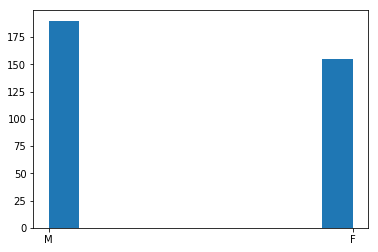

In [65]:
plt.hist(gender,bins='auto')

In [66]:
sub_y_train_ages=ages[0:num_train_samples]
sub_y_test_ages=ages[300:300+num_test_samples]
len(sub_y_test_ages)

45

In [67]:
sub_y_train_ages=sub_y_train_ages.reshape(-1,1)
sub_y_test_ages=sub_y_test_ages.reshape(-1,1)

In [68]:
sub_y_train_gender=gender[0:num_train_samples]
sub_y_test_gender=gender[300:300+num_test_samples]
len(sub_y_test_gender)

45

In [69]:
sub_y_train_gender=sub_y_train_gender.reshape(-1,1)
sub_y_test_gender=sub_y_test_gender.reshape(-1,1)

In [68]:
# y_scaler = MinMaxScaler()
# sub_y_train_ages=y_scaler.fit_transform(sub_y_train_ages)
# sub_y_test_ages=y_scaler.fit_transform(sub_y_test_ages)

In [23]:
model.evaluate_generator(generator=test_generator,steps=4)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


1.1430512368679047

In [16]:
path_checkpoint = 'checkpoint_conv1d_int32_5_just_conv1D_dense.keras'
model.load_weights(path_checkpoint)

NameError: name 'model' is not defined

In [72]:
model.evaluate_generator(generator=test_generator,steps=4)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


2.631558390930877e-05

In [74]:
model1 = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [34]:
# feature_maps_train = model1.predict(sub_x_train)
# feature_maps_test = model1.predict(sub_x_test)
# print(feature_maps_train.shape)
# print(feature_maps_test.shape)

In [ ]:
#extracting embeddings
path_checkpoints = 'checkpoint_conv1d_int32_5_just_conv1D_dense.keras'
model.load_weights(path_checkpoints)
model1 = Model(inputs=model.inputs, outputs=model.layers[2].output)
feature_maps_train = model1.predict(sub_x_train)
feature_maps_test = model1.predict(sub_x_test)
print(feature_maps_train.shape)
print(feature_maps_test.shape)
units=64
feature_maps_train=feature_maps_train.reshape(num_train_samples,subsequences*timesteps,units)
feature_maps_test=feature_maps_test.reshape(num_test_samples,subsequences*timesteps,units)
feature_maps_train=feature_maps_train[:,:1].reshape(num_train_samples,units)
feature_maps_test=feature_maps_test[:,:1].reshape(num_test_samples,units)
pick_data={
    'feature_maps_train':feature_maps_train,
    'feature_maps_test':feature_maps_test
}
with open('convDense_5FfeaEmb_downsampled.pkl', 'wb') as handle:
    pickle.dump(pick_data,handle)

In [75]:
filename='convDense_5FfeaEmb_downsampled.pkl'
new_data=read_pickleFile(filename)
feature_maps_train=new_data['feature_maps_train']
feature_maps_test=new_data['feature_maps_test']

In [76]:
# feature_maps_train=feature_maps_train[:,:1].reshape(num_train_samples,500)
# feature_maps_test=feature_maps_test[:,:1].reshape(num_test_samples,500)

In [81]:
labels=sub_y_train_ages.reshape(300,)
labels.shape

(300,)

(300, 2)
(300, 3)


/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


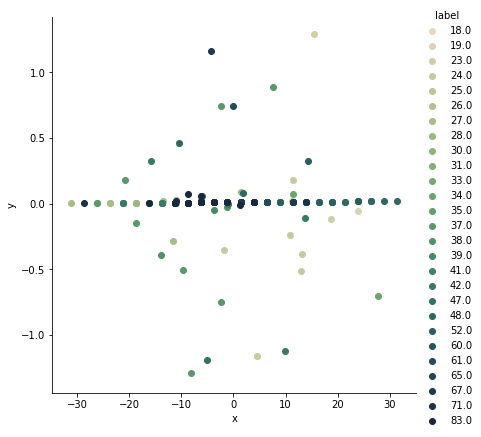

In [85]:
from sklearn.decomposition import PCA
import seaborn as sn
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(feature_maps_train)
print(principalComponents.shape)

pca_data=np.vstack((principalComponents.T,labels)).T
print(pca_data.shape)
principalDf = pd.DataFrame(data = pca_data
             , columns = ['x', 'y','label'])
pa=sn.cubehelix_palette(27, start=0.1, rot=-0.7)
sn.FacetGrid(principalDf,hue="label",size=6,palette=pa).map(plt.scatter,'x', 'y').add_legend()
plt.show()

In [86]:
# import plotly.express as px
# # df = px.data.iris()
# # print(df)
# fig = px.scatter_3d(principalDf, x='x', y='y', z='z',
#               color='label')
# fig.show()

In [87]:
labels=sub_y_train_gender.reshape(300,)
labels.shape

(300,)

In [89]:
from sklearn.decomposition import PCA
import seaborn as sn
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(feature_maps_train)
print(principalComponents.shape)

pcaData=np.vstack((principalComponents.T,labels)).T
print(pcaData.shape)
dataDf = pd.DataFrame(data = pcaData
             , columns = ['x', 'y','label'])


(300, 2)
(300, 3)


In [90]:
# import plotly.express as px
# # df = px.data.iris()
# # print(df)
# fig = px.scatter_3d(principalDf, x='x', y='y', z='z',
#               color='label')
# fig.show()

In [95]:
# pca = PCA(n_components=22)
# feature_maps_train = pca.fit_transform(feature_maps_train)
# feature_maps_test = pca.fit_transform(feature_maps_test)
# feature_maps_train

In [53]:
for i in range(4):
    model.layers[i].trainable = False
#     print(i)

In [90]:
sub_y_train_gender_bi=sub_y_train_gender.reshape(300,)
sub_y_test_gender_bi=sub_y_test_gender.reshape(45,)

In [97]:
sub_y_train_gender_binary=[]
sub_y_test_gender_binary=[]
for i in sub_y_train_gender_bi:
    if i =='F':
        sub_y_train_gender_binary.append(0)
    elif i=='M':
        sub_y_train_gender_binary.append(1)
        
for i in sub_y_test_gender_bi:
    if i =='F':
        sub_y_test_gender_binary.append(0)
    elif i=='M':
        sub_y_test_gender_binary.append(1)
sub_y_train_gender_binary=np.asarray(sub_y_train_gender_binary)
sub_y_test_gender_binary=np.asarray(sub_y_test_gender_binary)

In [94]:
sub_y_test_gender_bi

array(['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'M',
       'F', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'M',
       'F', 'M', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F',
       'M', 'M', 'M', 'F', 'F', 'F'], dtype='<U1')

In [98]:
sub_y_test_gender_binary

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0])

In [109]:
path_checkpoint = 'checkpoint_gender_v1.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./logs/checkpoint_gender_v1/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=0.001,
                                       patience=5,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [91]:
n_comp=64
input_layer = Input(shape=(n_comp))
ll=Dense(32,activation="relu",kernel_regularizer=l2(0.5))(input_layer)
ll=Dropout(0.5)(ll)
ll=Dense(32,activation="relu",kernel_regularizer=l2(0.5))(ll)
ll=Dense(1)(ll)
new_model = Model(inputs=input_layer,outputs=ll)

In [92]:
new_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


In [181]:
from tensorflow.keras.losses import BinaryCrossentropy,categorical_crossentropy
new_model.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [182]:
validation_data = (feature_maps_test,
                  sub_y_test_gender_binary)

In [183]:
new_model.fit(feature_maps_train,sub_y_train_ages,batch_size=32,
                    epochs=1000,validation_data=validation_data,callbacks=callbacks)

Train on 300 samples, validate on 45 samples
Epoch 1/1000
 32/300 [==>...........................] - ETA: 3s - loss: 6.0852 - accuracy: 0.6250
Epoch 00001: val_loss did not improve from 0.75452
300/300 [==============================] - 1s 2ms/sample - loss: 6.8463 - accuracy: 0.5733 - val_loss: 9.4542 - val_accuracy: 0.4000
Epoch 2/1000
 32/300 [==>...........................] - ETA: 0s - loss: 8.8823 - accuracy: 0.4375
Epoch 00002: val_loss did not improve from 0.75452
300/300 [==============================] - 0s 114us/sample - loss: 6.7877 - accuracy: 0.5733 - val_loss: 9.4004 - val_accuracy: 0.4000
Epoch 3/1000
 32/300 [==>...........................] - ETA: 0s - loss: 5.9694 - accuracy: 0.6250
Epoch 00003: val_loss did not improve from 0.75452
300/300 [==============================] - 0s 121us/sample - loss: 6.7374 - accuracy: 0.5733 - val_loss: 9.3548 - val_accuracy: 0.4000
Epoch 4/1000
 32/300 [==>...........................] - ETA: 0s - loss: 7.3534 - accuracy: 0.5312
Epoch 0

Epoch 30/1000
 32/300 [==>...........................] - ETA: 0s - loss: 7.1482 - accuracy: 0.5312
Epoch 00030: val_loss did not improve from 0.75452
300/300 [==============================] - 0s 110us/sample - loss: 6.5065 - accuracy: 0.5733 - val_loss: 9.1497 - val_accuracy: 0.4000
Epoch 31/1000
 32/300 [==>...........................] - ETA: 0s - loss: 5.7186 - accuracy: 0.6250
Epoch 00031: val_loss did not improve from 0.75452
300/300 [==============================] - 0s 122us/sample - loss: 6.5064 - accuracy: 0.5733 - val_loss: 9.1496 - val_accuracy: 0.4000
Epoch 32/1000
 32/300 [==>...........................] - ETA: 0s - loss: 7.6247 - accuracy: 0.5000
Epoch 00032: val_loss did not improve from 0.75452
300/300 [==============================] - 0s 127us/sample - loss: 6.5064 - accuracy: 0.5733 - val_loss: 9.1496 - val_accuracy: 0.4000
Epoch 33/1000
 32/300 [==>...........................] - ETA: 0s - loss: 7.1481 - accuracy: 0.5312
Epoch 00033: val_loss did not improve from 0.7

In [184]:
gender_predictions=new_model.predict(feature_maps_test)
gender_predictions

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [73]:

new_model.compile(loss='mean_squared_error', optimizer='adam')

In [74]:
validation_data = (feature_maps_test,
                  sub_y_test_ages)

In [75]:
# model.evaluate(x_test_neuron, y_test_neuron_scaled)
# %%time
new_model.fit(feature_maps_train,sub_y_train_ages,
                    epochs=3000,validation_data=validation_data,callbacks=callbacks)

Train on 32 samples, validate on 8 samples
Epoch 1/3000

Epoch 00001: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 13ms/sample - loss: 2.8925 - val_loss: 5.1919
Epoch 2/3000

Epoch 00002: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 559us/sample - loss: 4.5467 - val_loss: 3.2417
Epoch 3/3000

Epoch 00003: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 354us/sample - loss: 2.9729 - val_loss: 2.7421
Epoch 4/3000

Epoch 00004: val_loss did not improve from 0.14030

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 356us/sample - loss: 2.8256 - val_loss: 3.0789
Epoch 5/3000

Epoch 00005: val_loss did not improve from 0.14030

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 342us/sample - loss: 3.3189 - val_loss: 3.0073
Epoch 6/3000

Epoch 00006: val_loss did not impr

Epoch 49/3000

Epoch 00049: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 411us/sample - loss: 1.5794 - val_loss: 1.6463
Epoch 50/3000

Epoch 00050: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 423us/sample - loss: 1.5551 - val_loss: 1.6274
Epoch 51/3000

Epoch 00051: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 416us/sample - loss: 1.5302 - val_loss: 1.6069
Epoch 52/3000

Epoch 00052: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 407us/sample - loss: 1.5180 - val_loss: 1.5879
Epoch 53/3000

Epoch 00053: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 443us/sample - loss: 1.5094 - val_loss: 1.5711
Epoch 54/3000

Epoch 00054: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 429us/sample - loss: 1.4799 - val_loss: 1.5586
Epoch 55/3000

Epoch 00055: val_loss did not improve from 

Epoch 101/3000

Epoch 00101: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 459us/sample - loss: 1.0618 - val_loss: 1.1318
Epoch 102/3000

Epoch 00102: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 419us/sample - loss: 1.0460 - val_loss: 1.1232
Epoch 103/3000

Epoch 00103: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 494us/sample - loss: 1.0575 - val_loss: 1.1167
Epoch 104/3000

Epoch 00104: val_loss did not improve from 0.14030

Epoch 00104: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 463us/sample - loss: 1.0443 - val_loss: 1.1192
Epoch 105/3000

Epoch 00105: val_loss did not improve from 0.14030

Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 466us/sample - loss: 1.0380 - val_loss: 1.1216
Epoch 106/3000

Epoch 00106: val_loss did not improve from 0.14030

Epoch 00106:

Epoch 150/3000

Epoch 00150: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 433us/sample - loss: 0.8409 - val_loss: 0.9188
Epoch 151/3000

Epoch 00151: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 420us/sample - loss: 0.8359 - val_loss: 0.9162
Epoch 152/3000

Epoch 00152: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 394us/sample - loss: 0.8399 - val_loss: 0.9113
Epoch 153/3000

Epoch 00153: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 403us/sample - loss: 0.8300 - val_loss: 0.9063
Epoch 154/3000

Epoch 00154: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 411us/sample - loss: 0.8324 - val_loss: 0.9032
Epoch 155/3000

Epoch 00155: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 434us/sample - loss: 0.8334 - val_loss: 0.8993
Epoch 156/3000

Epoch 00156: val_loss did not improv

Epoch 199/3000

Epoch 00199: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 440us/sample - loss: 0.7031 - val_loss: 0.7827
Epoch 200/3000

Epoch 00200: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 455us/sample - loss: 0.7037 - val_loss: 0.7814
Epoch 201/3000

Epoch 00201: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 439us/sample - loss: 0.6967 - val_loss: 0.7803
Epoch 202/3000

Epoch 00202: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 435us/sample - loss: 0.6938 - val_loss: 0.7789
Epoch 203/3000

Epoch 00203: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 421us/sample - loss: 0.6889 - val_loss: 0.7782
Epoch 204/3000

Epoch 00204: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 424us/sample - loss: 0.7007 - val_loss: 0.7764
Epoch 205/3000

Epoch 00205: val_loss did not improv

32/32 [==============================] - 0s 318us/sample - loss: 0.6122 - val_loss: 0.6897
Epoch 246/3000

Epoch 00246: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 412us/sample - loss: 0.6108 - val_loss: 0.6880
Epoch 247/3000

Epoch 00247: val_loss did not improve from 0.14030

Epoch 00247: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 414us/sample - loss: 0.6112 - val_loss: 0.6883
Epoch 248/3000

Epoch 00248: val_loss did not improve from 0.14030

Epoch 00248: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 447us/sample - loss: 0.6146 - val_loss: 0.6894
Epoch 249/3000

Epoch 00249: val_loss did not improve from 0.14030

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 405us/sample - loss: 0.6026 - val_loss: 0.6890
Epoch 250/3000

Epoch 00250: val_loss did not improve from 0.14030
32/32 [========

Epoch 288/3000

Epoch 00288: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 475us/sample - loss: 0.5433 - val_loss: 0.6206
Epoch 289/3000

Epoch 00289: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 429us/sample - loss: 0.5382 - val_loss: 0.6167
Epoch 290/3000

Epoch 00290: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 423us/sample - loss: 0.5433 - val_loss: 0.6156
Epoch 291/3000

Epoch 00291: val_loss did not improve from 0.14030

Epoch 00291: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 399us/sample - loss: 0.5400 - val_loss: 0.6160
Epoch 292/3000

Epoch 00292: val_loss did not improve from 0.14030

Epoch 00292: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 490us/sample - loss: 0.5363 - val_loss: 0.6180
Epoch 293/3000

Epoch 00293: val_loss did not improve from 0.14030

Epoch 00293:

Epoch 331/3000

Epoch 00331: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 418us/sample - loss: 0.4837 - val_loss: 0.5663
Epoch 332/3000

Epoch 00332: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 433us/sample - loss: 0.4830 - val_loss: 0.5647
Epoch 333/3000

Epoch 00333: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 419us/sample - loss: 0.4794 - val_loss: 0.5625
Epoch 334/3000

Epoch 00334: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 409us/sample - loss: 0.4779 - val_loss: 0.5622
Epoch 335/3000

Epoch 00335: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 410us/sample - loss: 0.4785 - val_loss: 0.5616
Epoch 336/3000

Epoch 00336: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 429us/sample - loss: 0.4787 - val_loss: 0.5601
Epoch 337/3000

Epoch 00337: val_loss did not improv


Epoch 00377: val_loss did not improve from 0.14030

Epoch 00377: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 443us/sample - loss: 0.4326 - val_loss: 0.5161
Epoch 378/3000

Epoch 00378: val_loss did not improve from 0.14030

Epoch 00378: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 481us/sample - loss: 0.4336 - val_loss: 0.5132
Epoch 379/3000

Epoch 00379: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 340us/sample - loss: 0.4315 - val_loss: 0.5108
Epoch 380/3000

Epoch 00380: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 355us/sample - loss: 0.4322 - val_loss: 0.5068
Epoch 381/3000

Epoch 00381: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 471us/sample - loss: 0.4279 - val_loss: 0.5056
Epoch 382/3000

Epoch 00382: val_loss did not improve from 0.14030

Epoch 00382: ReduceLROnPlat

Epoch 418/3000

Epoch 00418: val_loss did not improve from 0.14030

Epoch 00418: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 472us/sample - loss: 0.3921 - val_loss: 0.4767
Epoch 419/3000

Epoch 00419: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 407us/sample - loss: 0.3958 - val_loss: 0.4744
Epoch 420/3000

Epoch 00420: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 496us/sample - loss: 0.3899 - val_loss: 0.4713
Epoch 421/3000

Epoch 00421: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 485us/sample - loss: 0.3893 - val_loss: 0.4685
Epoch 422/3000

Epoch 00422: val_loss did not improve from 0.14030

Epoch 00422: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 483us/sample - loss: 0.3907 - val_loss: 0.4690
Epoch 423/3000

Epoch 00423: val_loss did not improve from 0.14030

Epoch 00423:

Epoch 462/3000

Epoch 00462: val_loss did not improve from 0.14030

Epoch 00462: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 447us/sample - loss: 0.3542 - val_loss: 0.4403
Epoch 463/3000

Epoch 00463: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 402us/sample - loss: 0.3549 - val_loss: 0.4370
Epoch 464/3000

Epoch 00464: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 475us/sample - loss: 0.3552 - val_loss: 0.4342
Epoch 465/3000

Epoch 00465: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 434us/sample - loss: 0.3542 - val_loss: 0.4328
Epoch 466/3000

Epoch 00466: val_loss did not improve from 0.14030

Epoch 00466: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 440us/sample - loss: 0.3552 - val_loss: 0.4328
Epoch 467/3000

Epoch 00467: val_loss did not improve from 0.14030

Epoch 00467:

Epoch 504/3000

Epoch 00504: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 354us/sample - loss: 0.3231 - val_loss: 0.4030
Epoch 505/3000

Epoch 00505: val_loss did not improve from 0.14030

Epoch 00505: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 423us/sample - loss: 0.3243 - val_loss: 0.4063
Epoch 506/3000

Epoch 00506: val_loss did not improve from 0.14030

Epoch 00506: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 449us/sample - loss: 0.3248 - val_loss: 0.4110
Epoch 507/3000

Epoch 00507: val_loss did not improve from 0.14030

Epoch 00507: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 370us/sample - loss: 0.3241 - val_loss: 0.4130
Epoch 508/3000

Epoch 00508: val_loss did not improve from 0.14030

Epoch 00508: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 

Epoch 544/3000

Epoch 00544: val_loss did not improve from 0.14030

Epoch 00544: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 451us/sample - loss: 0.2966 - val_loss: 0.3822
Epoch 545/3000

Epoch 00545: val_loss did not improve from 0.14030

Epoch 00545: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 427us/sample - loss: 0.2973 - val_loss: 0.3832
Epoch 546/3000

Epoch 00546: val_loss did not improve from 0.14030

Epoch 00546: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 428us/sample - loss: 0.3021 - val_loss: 0.3832
Epoch 547/3000

Epoch 00547: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 434us/sample - loss: 0.3001 - val_loss: 0.3810
Epoch 548/3000

Epoch 00548: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 411us/sample - loss: 0.2979 - val_loss: 0.3767
Epoch 549/3000


Epoch 584/3000

Epoch 00584: val_loss did not improve from 0.14030

Epoch 00584: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 430us/sample - loss: 0.2769 - val_loss: 0.3617
Epoch 585/3000

Epoch 00585: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 378us/sample - loss: 0.2762 - val_loss: 0.3573
Epoch 586/3000

Epoch 00586: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 416us/sample - loss: 0.2752 - val_loss: 0.3541
Epoch 587/3000

Epoch 00587: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 428us/sample - loss: 0.2738 - val_loss: 0.3520
Epoch 588/3000

Epoch 00588: val_loss did not improve from 0.14030

Epoch 00588: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 445us/sample - loss: 0.2736 - val_loss: 0.3521
Epoch 589/3000

Epoch 00589: val_loss did not improve from 0.14030

Epoch 00589:

Epoch 626/3000

Epoch 00626: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 460us/sample - loss: 0.2578 - val_loss: 0.3334
Epoch 627/3000

Epoch 00627: val_loss did not improve from 0.14030

Epoch 00627: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 424us/sample - loss: 0.2539 - val_loss: 0.3346
Epoch 628/3000

Epoch 00628: val_loss did not improve from 0.14030

Epoch 00628: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 445us/sample - loss: 0.2568 - val_loss: 0.3376
Epoch 629/3000

Epoch 00629: val_loss did not improve from 0.14030

Epoch 00629: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 413us/sample - loss: 0.2516 - val_loss: 0.3421
Epoch 630/3000

Epoch 00630: val_loss did not improve from 0.14030

Epoch 00630: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 

Epoch 667/3000

Epoch 00667: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 410us/sample - loss: 0.2372 - val_loss: 0.3173
Epoch 668/3000

Epoch 00668: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 388us/sample - loss: 0.2378 - val_loss: 0.3156
Epoch 669/3000

Epoch 00669: val_loss did not improve from 0.14030

Epoch 00669: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 445us/sample - loss: 0.2363 - val_loss: 0.3165
Epoch 670/3000

Epoch 00670: val_loss did not improve from 0.14030

Epoch 00670: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 508us/sample - loss: 0.2371 - val_loss: 0.3183
Epoch 671/3000

Epoch 00671: val_loss did not improve from 0.14030

Epoch 00671: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 436us/sample - loss: 0.2356 - val_loss: 0.3198
Epoch 672/3000


Epoch 707/3000

Epoch 00707: val_loss did not improve from 0.14030

Epoch 00707: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 440us/sample - loss: 0.2236 - val_loss: 0.3047
Epoch 708/3000

Epoch 00708: val_loss did not improve from 0.14030

Epoch 00708: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 545us/sample - loss: 0.2220 - val_loss: 0.3045
Epoch 709/3000

Epoch 00709: val_loss did not improve from 0.14030

Epoch 00709: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 442us/sample - loss: 0.2207 - val_loss: 0.3032
Epoch 710/3000

Epoch 00710: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 418us/sample - loss: 0.2203 - val_loss: 0.3002
Epoch 711/3000

Epoch 00711: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 403us/sample - loss: 0.2169 - val_loss: 0.2998
Epoch 712/3000


Epoch 749/3000

Epoch 00749: val_loss did not improve from 0.14030

Epoch 00749: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 423us/sample - loss: 0.2064 - val_loss: 0.2920
Epoch 750/3000

Epoch 00750: val_loss did not improve from 0.14030

Epoch 00750: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 432us/sample - loss: 0.2063 - val_loss: 0.2923
Epoch 751/3000

Epoch 00751: val_loss did not improve from 0.14030

Epoch 00751: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 431us/sample - loss: 0.2058 - val_loss: 0.2898
Epoch 752/3000

Epoch 00752: val_loss did not improve from 0.14030

Epoch 00752: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 441us/sample - loss: 0.2083 - val_loss: 0.2874
Epoch 753/3000

Epoch 00753: val_loss did not improve from 0.14030
32/32 [==============================] - 

Epoch 789/3000

Epoch 00789: val_loss did not improve from 0.14030

Epoch 00789: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 440us/sample - loss: 0.1930 - val_loss: 0.2762
Epoch 790/3000

Epoch 00790: val_loss did not improve from 0.14030

Epoch 00790: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 456us/sample - loss: 0.1939 - val_loss: 0.2774
Epoch 791/3000

Epoch 00791: val_loss did not improve from 0.14030

Epoch 00791: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 405us/sample - loss: 0.1926 - val_loss: 0.2781
Epoch 792/3000

Epoch 00792: val_loss did not improve from 0.14030

Epoch 00792: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 397us/sample - loss: 0.1959 - val_loss: 0.2756
Epoch 793/3000

Epoch 00793: val_loss did not improve from 0.14030

Epoch 00793: ReduceLROnPlateau reducing 

Epoch 828/3000

Epoch 00828: val_loss did not improve from 0.14030

Epoch 00828: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 431us/sample - loss: 0.1798 - val_loss: 0.2620
Epoch 829/3000

Epoch 00829: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 455us/sample - loss: 0.1829 - val_loss: 0.2613
Epoch 830/3000

Epoch 00830: val_loss did not improve from 0.14030

Epoch 00830: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 491us/sample - loss: 0.1821 - val_loss: 0.2664
Epoch 831/3000

Epoch 00831: val_loss did not improve from 0.14030

Epoch 00831: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 444us/sample - loss: 0.1789 - val_loss: 0.2713
Epoch 832/3000

Epoch 00832: val_loss did not improve from 0.14030

Epoch 00832: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 

Epoch 867/3000

Epoch 00867: val_loss did not improve from 0.14030

Epoch 00867: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 442us/sample - loss: 0.1756 - val_loss: 0.2596
Epoch 868/3000

Epoch 00868: val_loss did not improve from 0.14030

Epoch 00868: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 435us/sample - loss: 0.1714 - val_loss: 0.2542
Epoch 869/3000

Epoch 00869: val_loss did not improve from 0.14030

Epoch 00869: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 436us/sample - loss: 0.1741 - val_loss: 0.2519
Epoch 870/3000

Epoch 00870: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 416us/sample - loss: 0.1728 - val_loss: 0.2506
Epoch 871/3000

Epoch 00871: val_loss did not improve from 0.14030

Epoch 00871: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 

Epoch 906/3000

Epoch 00906: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 379us/sample - loss: 0.1631 - val_loss: 0.2426
Epoch 907/3000

Epoch 00907: val_loss did not improve from 0.14030
32/32 [==============================] - 0s 426us/sample - loss: 0.1624 - val_loss: 0.2416
Epoch 908/3000

Epoch 00908: val_loss did not improve from 0.14030

Epoch 00908: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 438us/sample - loss: 0.1641 - val_loss: 0.2442
Epoch 909/3000

Epoch 00909: val_loss did not improve from 0.14030

Epoch 00909: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 428us/sample - loss: 0.1631 - val_loss: 0.2487
Epoch 910/3000

Epoch 00910: val_loss did not improve from 0.14030

Epoch 00910: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 428us/sample - loss: 0.1644 - val_loss: 0.2498
Epoch 911/3000


Epoch 945/3000

Epoch 00945: val_loss did not improve from 0.14030

Epoch 00945: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 459us/sample - loss: 0.1563 - val_loss: 0.2424
Epoch 946/3000

Epoch 00946: val_loss did not improve from 0.14030

Epoch 00946: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 454us/sample - loss: 0.1577 - val_loss: 0.2405
Epoch 947/3000

Epoch 00947: val_loss did not improve from 0.14030

Epoch 00947: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 422us/sample - loss: 0.1523 - val_loss: 0.2395
Epoch 948/3000

Epoch 00948: val_loss did not improve from 0.14030

Epoch 00948: ReduceLROnPlateau reducing learning rate to 0.001.
32/32 [==============================] - 0s 426us/sample - loss: 0.1554 - val_loss: 0.2367
Epoch 949/3000

Epoch 00949: val_loss did not improve from 0.14030

Epoch 00949: ReduceLROnPlateau reducing 

Epoch 00982: early stopping


In [76]:
predictions=new_model.predict(feature_maps_test)

In [77]:
real_predicted_ages=y_scaler.inverse_transform(predictions)
real_predicted_ages

array([[47.825874],
       [50.147484],
       [51.1949  ],
       [52.383904],
       [52.61747 ],
       [50.32719 ],
       [47.30997 ],
       [52.948772]], dtype=float32)

In [78]:
true_ages=y_scaler.inverse_transform(sub_y_test_ages)
true_ages

array([[24.],
       [24.],
       [83.],
       [65.],
       [28.],
       [42.],
       [24.],
       [26.]])

In [94]:
#time axis
time=time_df.iloc[0:50500].values
# time=time[0::20]
time=time.reshape((time.shape[1],time.shape[0]))
len(time[0])

50500

In [93]:
#To save reconstructed samples
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# scaler = StandardScaler()
# for i in range(0,45):
#     y=x_test[sequence_length*i:(sequence_length*i)+sequence_length]
#     # x=x_test[50500]
#     # print("Min:", np.min(y))
#     # print("Max:", np.max(y))
#     y=scaler.fit_transform(y)
#     # print("Min:", np.min(y))
#     # print("Max:", np.max(y))
#     len(y)
#     y=y.reshape(1,5,10100,1)

#     y_to=y.reshape(sequence_length,)
#     predicted = model.predict(y)
#     # print("Min:", np.min(predicted))
#     # print("Max:", np.max(predicted))
#     predicted=predicted.reshape(sequence_length,)
#     plt.scatter(time[0], predicted,c='b',label='predicted')
#     plt.plot(time[0],y_to, c='r',label='true')
#     plt.legend()
#     plt.savefig('/home/sarmi141294/MSProject_data/samples/checkpoint_downsampled_4conv1D_stride_dense/'+str(i))
#     plt.cla()
#     plt.clf() 